In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install shap

In [3]:
!pip install catboost
!pip install lightgbm
!pip install ngboost
!pip install shap

In [24]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Essentials
import numpy as np
import pandas as pd
import random
import time
import gc
import os
from datetime import datetime

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns
# matplotlib 의 기본 scheme 말고
# seaborn scheme 을 세팅하여, 일일이 graph의 font size 지정할 필요 없이
# seaborn 의 font_scale 을 사용하는 것을 추천드립니다.
plt.style.use('seaborn')
sns.set(font_scale=2.5)
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 80,60

# Models
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from ngboost import NGBClassifier, NGBRegressor
from lightgbm.plotting import plot_importance
import lightgbm
import xgboost as xgb
import catboost
from xgboost import plot_tree

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


# Misc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV # 최상의 하이퍼 파라미터를 선정해주는 라이브러리
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import OneHotEncoder # 모든 변수를 0과 1로만 표현. 그래서 변수 개수 만큼의 0과 1을 나타내야할 matrix 필요.
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from dateutil import tz
from geopy import distance
import shap

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

<Figure size 1600x800 with 0 Axes>

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lending_club/lending_club_2020_train.csv')

In [25]:
column_types = df.dtypes

# float와 object로 나누기
float_columns = []
object_columns = []
for column_name, dtype in column_types.items():
    if dtype == 'float':
        float_columns.append(column_name)
    elif dtype == 'object':
        object_columns.append(column_name)

print("Float 열:", float_columns)
print("Object 열:", object_columns)

Float 열: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_

In [26]:
#'settlement_status' in float_columns

In [27]:
#'settlement_status' in object_columns

우선 float자료형으로 밑에 모델을 돌려볼 예정

In [28]:
# 타겟 변수 추가. 이건 bin 형태여서 0,1로 변경 예정
float_columns.append('debt_settlement_flag')

In [29]:
df = df[float_columns]

In [30]:
# 결측치 우선 0으로 채움
df.fillna(0, inplace = True)

In [31]:
# 결측치 있나 확인
#df.isnull().sum()

In [32]:
#df['debt_settlement_flag'] == 'Y'

In [33]:
df['target'] = df['debt_settlement_flag'] == 'Y'
df['target'] = df['target'].astype('int')

In [34]:
# 우선 랜덤하게 data_split하고 돌려봄 6:2:2
df_train, df_test = train_test_split(df, test_size = .2, train_size = .8, random_state = 42)
df_train, df_validation = train_test_split(df_train, test_size = .25, train_size = 0.75, random_state = 42)

In [35]:
df_train.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,target
count,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1053177.0,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06,1.053177e+06
mean,1.535042e+04,1.534633e+04,1.533145e+04,4.520167e+02,7.994741e+04,1.927715e+01,2.891366e-01,7.005539e+02,7.045541e+02,5.547700e-01,1.658305e+01,1.091731e+01,1.167912e+01,1.762999e-01,1.693749e+04,2.402007e+01,4.033125e+03,4.032548e+03,1.257369e+04,1.255888e+04,9.918217e+03,2.483824e+03,1.765855e+00,1.698854e+02,2.903722e+01,3.477322e+03,6.904397e+02,6.779534e+02,1.770737e-02,1.100575e+01,1.0,9.421730e+03,1.405481e+00,3.364107e-03,2.080650e+02,1.419552e+05,6.555052e-01,1.988854e+00,4.923522e-01,1.127998e+00,1.392663e+01,2.591996e+04,4.168138e+01,8.806307e-01,1.859148e+00,4.231216e+03,3.958377e+01,3.546175e+04,7.551171e-01,1.067805e+00,1.410697e+00,4.411266e+00,1.338677e+04,1.234557e+04,5.426255e+01,8.019545e-03,9.818222e+00,1.191385e+02,1.753456e+02,1.412357e+01,8.145947e+00,1.485055e+00,2.438638e+01,8.721924e+00,6.199204e+00,1.145

In [36]:
def show_time(diff):
   m, s = divmod(diff, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def Train(clf, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    model = clf.fit(X,y)
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('\nPrediction time: ')
    show_time(end - start)
    return model

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def GridSearch(clf, params, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    if(type=='classification'):
        model = GridSearchCV(clf, params, scoring='accuracy', n_jobs=-1, cv=5).fit(X,y).best_estimator_
    else:
        model = GridSearchCV(clf, params, scoring='r2', n_jobs=-1, cv=5).fit(X,y).best_estimator_
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('Prediction time: ')
    show_time(end - start)
    return model

# Takes in model scores and plots them on a bar graph
def plot_metric(model_scores, score='Accuracy'):
    # Set figure size
    rcParams['figure.figsize'] = 20,15
    plt.bar(model_scores['Model'], height=model_scores[score])
    xlocs, xlabs = plt.xticks()
    xlocs=[i for i in range(0,17)]
    xlabs=[i for i in range(0,17)]
    if(score != 'Prediction Times'):
        for i, v in enumerate(model_scores[score]):
            plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
    plt.xlabel('Model')
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()

# Takes in training data and a model, and plots a bar graph of the model's feature importances
def feature_importances(df, model, model_name, max_num_features=10):
    feature_importances = pd.DataFrame(columns = ['feature', 'importance'])
    feature_importances['feature'] = df.columns
    feature_importances['importance'] = model.feature_importances_
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances = feature_importances[:max_num_features]
    print(feature_importances)
    plt.figure(figsize=(12, 6));
    sns.barplot(x="importance", y="feature", data=feature_importances);
    plt.title(model_name+' features importance:');

# Takes in training data and a model, and plots a bar graph of SHAP values
def shap_values(df, model, model_name):
    shap_values = shap.TreeExplainer(model).shap_values(df)
    shap_values[:5]
    shap.summary_plot(shap_values, df.iloc[:1000,:])

In [37]:
#df_train.shape

In [38]:
#df_test.shape

In [39]:
x_data = list(df_train.columns)
x_data.remove('target')
x_data.remove('debt_settlement_flag')
# x_data

In [40]:
X_train = df_train[x_data]
y_train = df_train['target']

X_test = df_validation[x_data]
y_test = df_validation['target']
# 하나하나 선택해도 되지만, 필요없는 columns은 진작에 삭제해버려도 좋을듯
# Target은 Survived

<a href='https://postimages.org/' target='_blank'><img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_svc_0011.png' border='0' alt='image'/></a>


In [41]:
from sklearn.metrics import accuracy_score

In [42]:
prediction_times = []
training_times = []
scores = []
# training_times
# prediction_times

# lin_svm = Train(LinearSVC(), X_train, y_train, X_test, y_test) # linear suppor vector machine
# non_lin_svm = Train(SVC(kernel='rbf'), X_train, y_train, X_test, y_test) # non ---
# decision_tree = Train(DecisionTreeClassifier(max_depth=5), X_train, y_train, X_test, y_test) # 결정트리
#random_forest= Train(RandomForestClassifier(n_estimators=50,max_depth=5), X_train, y_train, X_test, y_test) # 랜덤 포레스트. Essemble 중 bagging에 대표적인 모델
# extra_trees = Train(ExtraTreesClassifier(n_estimators=50,max_depth=5), X_train, y_train, X_test, y_test) # 랜덤 포레스트와 유사하지만, bagging은 아니다. 속도도 빠르고 bias도 varinace도 줄일 수 있다고 하지만... 최고라고 하기엔 흠?
xgboost = Train(XGBClassifier(n_estimators=50, max_depth=5), X_train, y_train, X_test, y_test)
lgb = Train(LGBMClassifier(n_estimators=50, max_depth=5), X_train, y_train, X_test, y_test)
cat = Train(CatBoostClassifier(n_estimators=50, verbose=False, max_depth=5), X_train, y_train, X_test, y_test)
ngb = Train(NGBClassifier(n_estimators=50, verbose=False, natural_gradient=False), X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:00:31

Prediction time: 
Execution Time: 00:00:01
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 18547, number of negative: 1034630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.659745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13941
[LightGBM] [Info] Number of data points in the train set: 1053177, number of used features: 105
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017611 -> initscore=-4.021491
[LightGBM] [Info] Start training from score -4.021491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

In [43]:
scores_l = scores[:]

In [44]:
X_train.shape

(1053177, 106)

In [45]:
X_train_reg = df_train[x_data]
y_train_reg = df_train['target']

X_test_reg = df_validation[x_data]
y_test_reg = df_validation['target']

In [46]:
prediction_times = []
training_times = []
scores = []
# training_times
# prediction_times

#reg_lin_svm = Train(LinearSVR(), X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')
#reg_non_lin_svm = Train(SVR(kernel='rbf'), X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')
#reg_decision_tree = Train(DecisionTreeRegressor(max_depth=5), X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')
#reg_random_forest= Train(RandomForestRegressor(n_estimators=50,max_depth=5), X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')
#reg_extra_trees = Train(ExtraTreesRegressor(n_estimators=50,max_depth=5), X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')
reg_xgboost = Train(XGBRegressor(n_estimators=50, max_depth=5), X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')
reg_lgb = Train(LGBMRegressor(n_estimators=50, max_depth=5), X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')
reg_cat = Train(CatBoostRegressor(n_estimators=50, verbose=False, max_depth=5), X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')
reg_ngb = Train(NGBRegressor(n_estimators=50, verbose=False, natural_gradient=False), X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')

Training time: 
Execution Time: 00:00:29

Prediction time: 
Execution Time: 00:00:01
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.703635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13941
[LightGBM] [Info] Number of data points in the train set: 1053177, number of used features: 105
[LightGBM] [Info] Start training from score 0.017611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [47]:
scores = scores + scores_l

In [48]:
scores[0], scores[1] = scores[1], scores[0]
scores

[0.006782256459804728,
 0.006112918595419956,
 0.006449792192286627,
 0.009615517074175692,
 0.9924571083493088,
 0.9911353931960155,
 0.992912872195272,
 0.9844613013766916]

In [55]:
models = [
    # ('LinearSVM', reg_lin_svm),
    # ('LinearSVM', lin_svm),
    # ('NonLinearSVM', non_lin_svm),
    # ('NonLinearSVM', reg_non_lin_svm),
    # ('DecisionTree', decision_tree),
    # ('DecisionTree', reg_decision_tree),
    #('RandomForest', random_forest),
    #('RandomForest', reg_random_forest),
    #  ('ExtraTrees', extra_trees),
    #  ('ExtraTrees', reg_extra_trees)
    ('XGBoost', xgboost),
    ('Reg_XGBoost', reg_xgboost),
    ('LightGBM', lgb),
    ('Reg_LightGBM', reg_lgb),
    ('CatBoost', cat),
    ('Reg_CatBoost', reg_cat),
    ('NgBoost', ngb),
    ('Reg_NgBoost', reg_ngb),
    # ('XGBoost GridSearch', xgboost_gs),
    # ('XGBoost GridSearch', reg_xgboost_gs),
    # ('LightGBM GridSearch', lgb_gs),
    # ('LightGBM GridSearch', reg_lgb_gs),
    # ('CatBoost GridSearch', cat_gs),
    # ('CatBoost GridSearch', reg_cat_gs),
    # ('NgBoost GridSearch', ngb_gs),
    # ('NgBoost GridSearch', reg_ngb_gs),
    # ('XGBoost GS EarlyStopping', xgboost_gs_es),
    # ('XGBoost GS EarlyStopping', reg_xgboost_gs_es),
    # ('LightGBM GS EarlyStopping', lgb_gs_es),
    # ('LightGBM GS EarlyStopping', reg_lgb_gs_es),
    # ('CatBoost GS EarlyStopping', cat_gs_es),
    # ('CatBoost GS EarlyStopping', reg_cat_gs_es),
    # ('NgBoost GS EarlyStopping', ngb_gs_es)
    # ('NgBoost GS EarlyStopping', reg_ngb_gs_es)
]

In [52]:
models

[('XGBoost',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=5, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=50, n_jobs=None,
                num_parallel_tree=None, random_state=None, ...)),
 ('XGBoost',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=

In [54]:
model_scores

,Model,R square
6,NgBoost,0.992913
4,CatBoost,0.992457
5,CatBoost,0.991135
7,NgBoost,0.984461
3,LightGBM,0.009616
0,XGBoost,0.006782
2,LightGBM,0.006450
1,XGBoost,0.006113


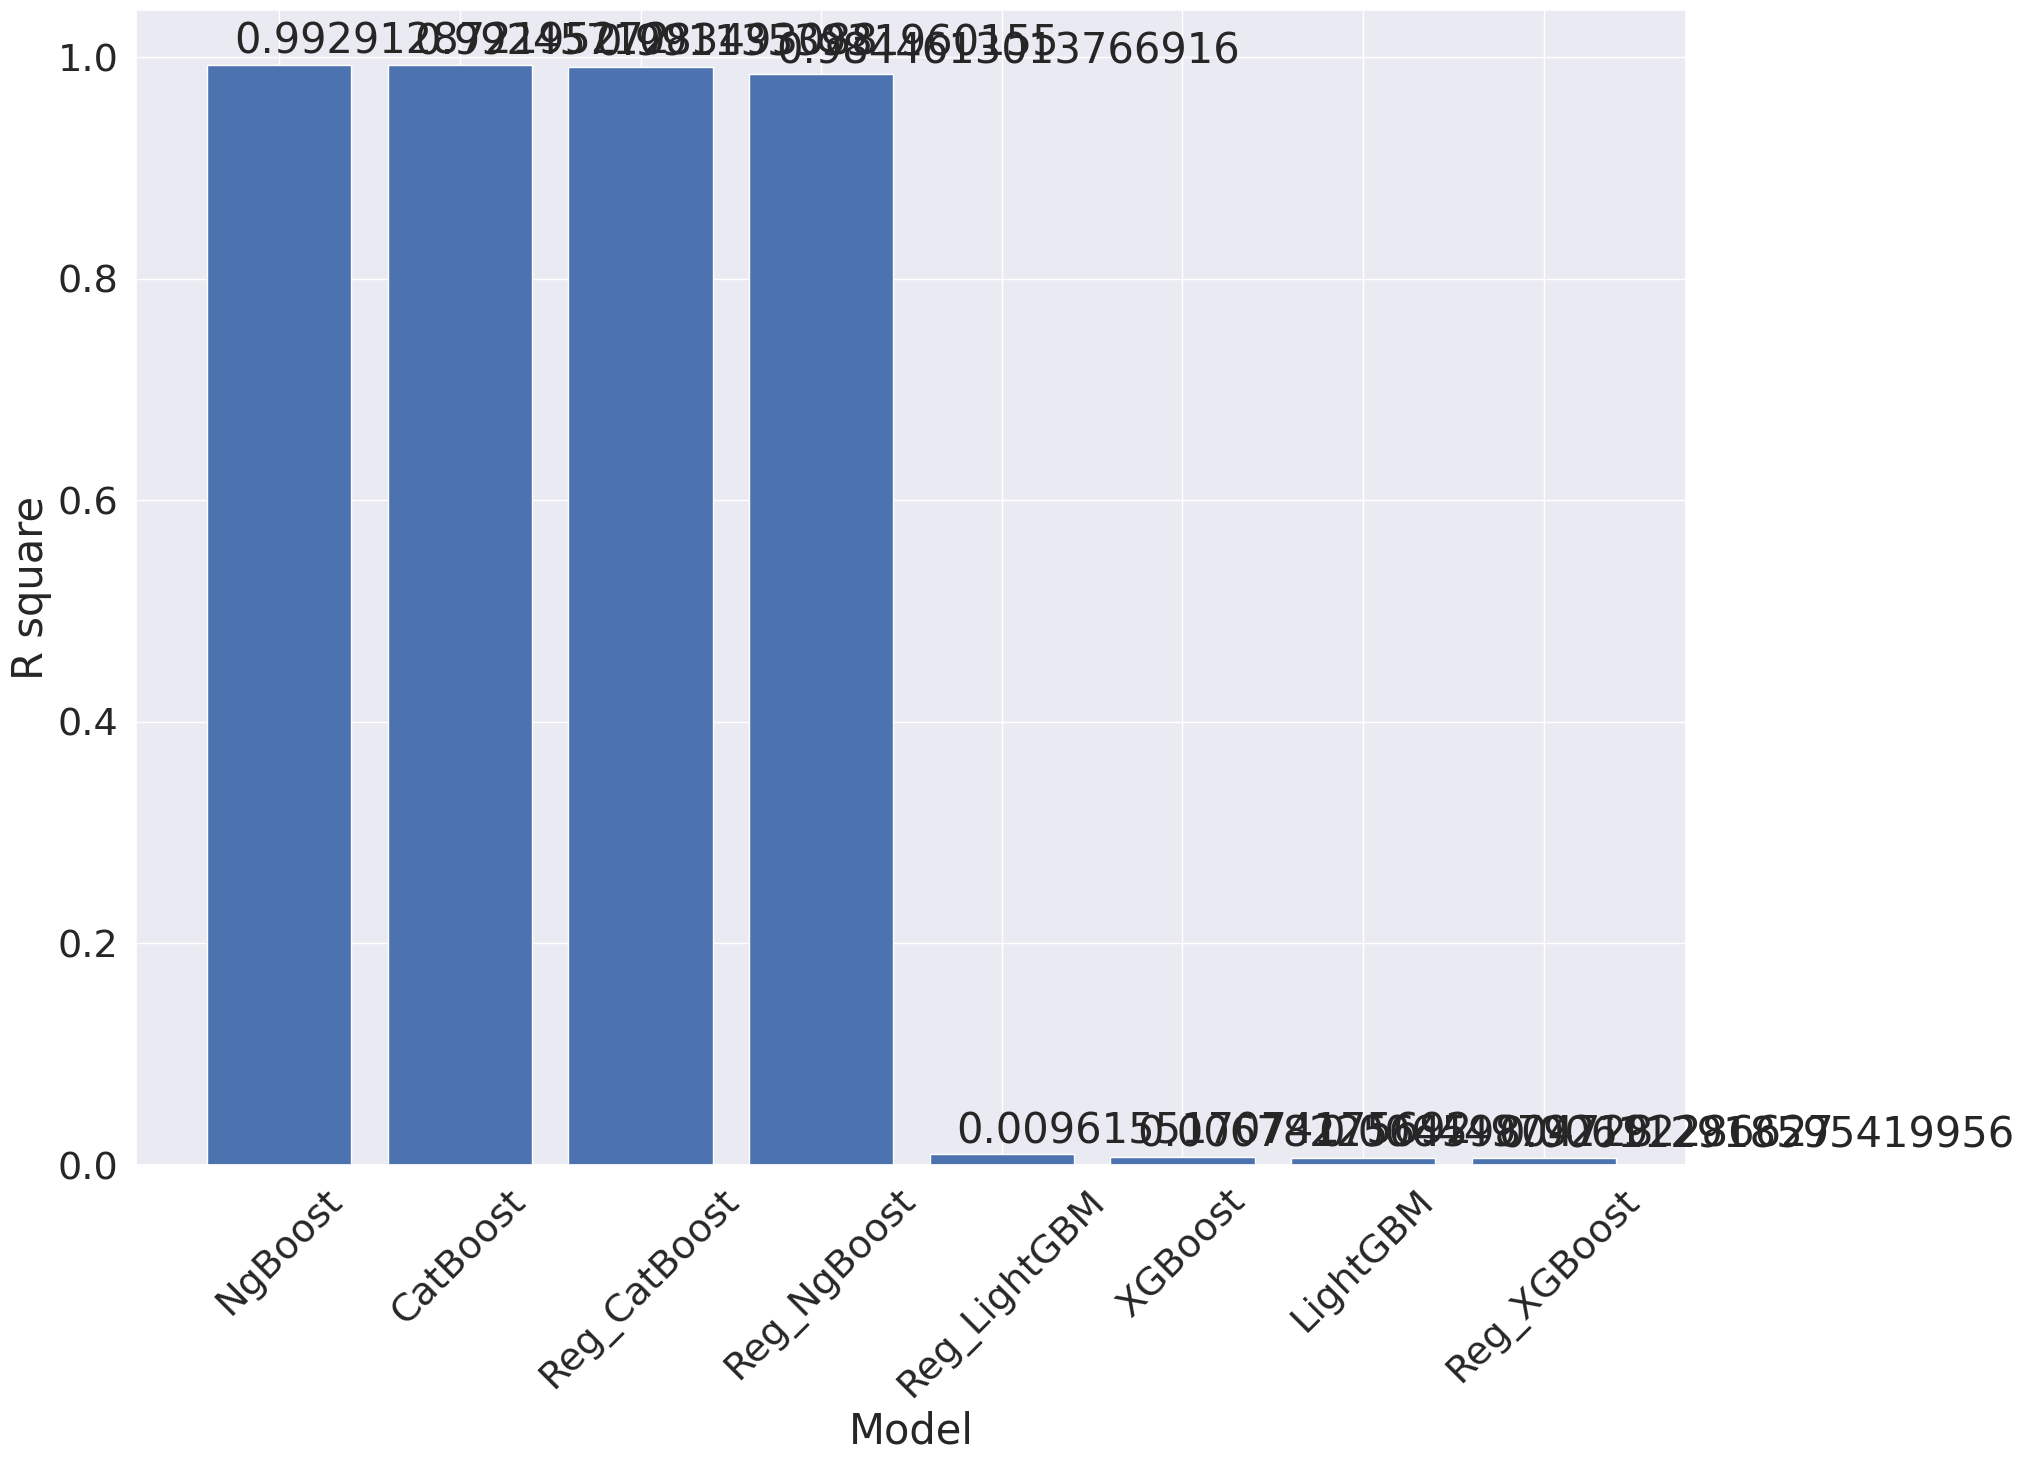

In [56]:
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'R square': scores })
model_scores.sort_values(by= 'R square',ascending=False,inplace=True)
plot_metric(model_scores, score= 'R square')